In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import yaml
import os
from datetime import datetime
import numpy as np
from utils import get_config2, resolve_path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py

# Custom modules
from dataset3 import APOGEEDataset
from model2 import Generator
from tqdm import tqdm
from checkpoint import save_checkpoint, load_checkpoint

In [2]:
def initialize_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

In [3]:
def load_configurations():
    config = get_config2()
    
    dataset_name = config['dataset_name']
    dataset_config = config['datasets'][dataset_name]
    data_path = resolve_path(dataset_config['path'])
    checkpoints_path = resolve_path(config['paths']['checkpoints'])
    latent_path = resolve_path(config['paths']['latent'])
    plots_path = resolve_path(config['paths']['plots'])

    batch_size = config['training']['batch_size']
    num_workers = config['training']['num_workers']
    num_epochs = config['training']['num_epochs']
    learning_rate = config['training']['learning_rate']
    latent_learning_rate = config['training']['latent_learning_rate']
    latent_dim = config['training']['latent_dim']
    checkpoint_interval = config['training']['checkpoint_interval']

    return (config, data_path, checkpoints_path, latent_path, plots_path, 
            batch_size, num_workers, num_epochs, learning_rate, latent_learning_rate, latent_dim, checkpoint_interval)

In [4]:
print("initializing device ..")
device = initialize_device()
print("loading config..")
(config, data_path, checkpoints_path, latent_path, plots_path,
 batch_size, num_workers, num_epochs, learning_rate, latent_learning_rate, latent_dim, checkpoint_interval) = load_configurations()

initializing device ..
Using device: cuda
loading config..


In [5]:
# def plot_real_vs_generated_batch(dataset, data_path, data_loader, generator, device, batch_index, plots_path):
#     # Open the HDF5 file
#     with h5py.File(data_path, 'r') as hdf5_file:

#         # Find the specific batch
#         batch = next((batch_data for i, batch_data in enumerate(data_loader) if i == batch_index), None)

#         # Ensure the batch is found
#         if batch is None:
#             raise ValueError(f"Batch index {batch_index} not found in the data loader.")

#         # Extract unique identifiers, real spectra, and masks from the batch
#         unique_ids = batch['unique_id']
#         real_spectra = batch['flux'].to(device)
#         masks = batch['flux_mask'].to(device)

#         # Generate the spectra using the generator model
#         generator.eval()
#         with torch.no_grad():
#             latent_codes = [torch.tensor(hdf5_file[uid]['latent_code'][()]).to(device) for uid in unique_ids]
#             latent_codes_tensor = torch.stack(latent_codes)
#             generated_spectra = generator(latent_codes_tensor).cpu().numpy()

#         # Plot real vs generated spectra for each item in the batch
#         for i, uid in enumerate(unique_ids):
#             real_spectrum = real_spectra[i].cpu().numpy()
#             generated_spectrum = generated_spectra[i]
#             mask = masks[i].cpu().numpy()

#             # Calculate weighted MSE or another appropriate metric
#             mse = np.mean((mask * (real_spectrum - generated_spectrum))**2) / np.mean(mask)

#             plt.figure(figsize=(10, 5))
#             plt.plot(real_spectrum, label='Real Spectrum', color='blue', alpha=0.7, linewidth=0.5)
#             plt.plot(generated_spectrum, label='Generated Spectrum', color='red', alpha=0.7, linewidth=0.5)
#             plt.title(f'Comparison of Real and Generated Spectra for {uid}\nMasked MSE: {mse:.4f}')
#             plt.xlabel('Wavelength Index')
#             plt.ylabel('Flux')
#             plt.legend()
#             plt.grid(True)
#             plt.savefig(os.path.join(plots_path, f'real_vs_generated_{uid}.png'))
#             plt.show()
#             plt.close()  



In [6]:

import h5py
# Initialize the dataset and data loader
dataset = APOGEEDataset(data_path, max_files=50)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Initialize the generator model
generator = Generator(config['training']['latent_dim'], config['model']['output_dim'], config['model']['generator_layers'], config['model']['activation_function']).to(device)

# Load the latest checkpoint if available
latest_checkpoint_path = os.path.join(checkpoints_path, 'checkpoint_latest.pth.tar')
print(latest_checkpoint_path)
if os.path.exists(latest_checkpoint_path):
    checkpoint = torch.load(latest_checkpoint_path)
    # print(checkpoint)
    generator.load_state_dict(checkpoint['state_dict'])



/arc/home/Amirabezine/deepSpectra/checkpoints/checkpoint_latest.pth.tar


In [7]:

# # # Plot the real vs generated spectra for the batch of index batc_index
# batch_index = 0
# plot_real_vs_generated_batch(dataset, data_path, data_loader, generator, device, batch_index, plots_path)

In [8]:
# def plot_latent_evolution_through_epochs(hdf5_file_path, data_loader, device, plots_path):
#     with h5py.File(hdf5_file_path, 'r') as hdf5_file:
#         # Get the first batch from the data loader
#         first_batch = next(iter(data_loader))
#         unique_ids = first_batch['unique_id']

#         # Prepare to collect latent codes for available epochs for each unique_id
#         latents_over_epochs = {uid: [] for uid in unique_ids}
#         epochs_available = {uid: [] for uid in unique_ids}

#         # Loop over each unique_id to fetch available latent codes
#         for uid in unique_ids:
#             # Find all keys for the current unique_id that contain latent vectors
#             keys = [key for key in hdf5_file[uid].keys() if key.startswith('latent_code_epoch_')]
#             epochs = [int(key.split('_')[-1]) for key in keys]
#             epochs.sort()
#             epochs_available[uid] = epochs

#             # Store the latent vectors for each available epoch
#             for epoch in epochs:
#                 latent_key = f"{uid}/latent_code_epoch_{epoch}"
#                 latent_vector = torch.tensor(hdf5_file[latent_key][()], dtype=torch.float32, device=device)
#                 latents_over_epochs[uid].append(latent_vector.cpu().numpy())

#         # Plotting the evolution of latent vectors
#         for uid, latents in latents_over_epochs.items():
#             latents = np.array(latents)  # Convert list of arrays into a 2D numpy array
#             epochs = epochs_available[uid]

#             plt.figure(figsize=(12, 6))
#             for i in range(latents.shape[1]):  # Assuming latents.shape[1] is the dimension of the latent vector
#                 plt.plot(epochs, latents[:, i], marker='o', linestyle='-', label=f'Latent Dimension {i+1}')

#             plt.title(f'Evolution of Latent Vectors for {uid} Across Epochs')
#             plt.xlabel('Epoch')
#             plt.ylabel('Latent Value')
#             plt.xticks(epochs)  # Ensure that all epochs are labeled
#             # plt.legend()
#             plt.grid(True)
#             plt.savefig(os.path.join(plots_path, f'latent_evolution_{uid}.png'))
#             plt.show()
#             plt.close()  # Close to free memory


In [9]:
# plot_latent_evolution_through_epochs(data_path, data_loader, device, plots_path)

In [10]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

def plot_real_vs_generated_batch(dataset, data_path, data_loader, generator, device, batch_index, plots_path):
    with h5py.File(data_path, 'r') as hdf5_file:
        batch = next((batch_data for i, batch_data in enumerate(data_loader) if i == batch_index), None)
        if batch is None:
            raise ValueError(f"Batch index {batch_index} not found in the data loader.")

        unique_ids = [uid.decode('utf-8') for uid in batch['unique_id']]
        real_spectra = batch['flux'].to(device)
        masks = batch['flux_mask'].to(device)

        generator.eval()
        generated_spectra = []
        latent_codes = []

        for uid in unique_ids:
            try:
                # Directly attempt to fetch the latent code
                latent_code = torch.tensor(hdf5_file[f"{uid}/optimized_latent_code/latest"][()]).to(device)
                latent_codes.append(latent_code)
            except KeyError:
                # Handle the absence of an optimized latent code
                print(f"No optimized latent code for {uid}, using initial latent code.")
                try:
                    latent_code = torch.tensor(hdf5_file[f"{uid}/latent_code"][()]).to(device)
                    latent_codes.append(latent_code)
                except KeyError:
                    print(f"No latent code available for {uid}, skipping.")
                    continue

        if latent_codes:
            latent_codes_tensor = torch.stack(latent_codes)
            with torch.no_grad():
                generated_spectra = generator(latent_codes_tensor).cpu().numpy()

            j = 0  # Index for generated spectra
            for i, uid in enumerate(unique_ids):
                if i >= len(latent_codes):
                    continue

                real_spectrum = real_spectra[i].cpu().numpy()
                generated_spectrum = generated_spectra[j]
                j += 1
                mask = masks[i].cpu().numpy()
                mse = np.mean((mask * (real_spectrum - generated_spectrum))**2) / np.mean(mask)

                plt.figure(figsize=(10, 5))
                plt.plot(real_spectrum, label='Real Spectrum', color='blue', alpha=0.7, linewidth=0.5)
                plt.plot(generated_spectrum, label='Generated Spectrum', color='red', alpha=0.7, linewidth=0.5)
                plt.title(f'Comparison of Real and Generated Spectra for {uid}\nMasked MSE: {mse:.4f}')
                plt.xlabel('Wavelength Index')
                plt.ylabel('Flux')
                plt.legend()
                plt.grid(True)
                plt.savefig(os.path.join(plots_path, f'real_vs_generated_{uid}.png'))
                plt.show()
                plt.close()



In [11]:
# plot_latent_evolution_through_epochs(data_path, data_loader, device, plots_path)

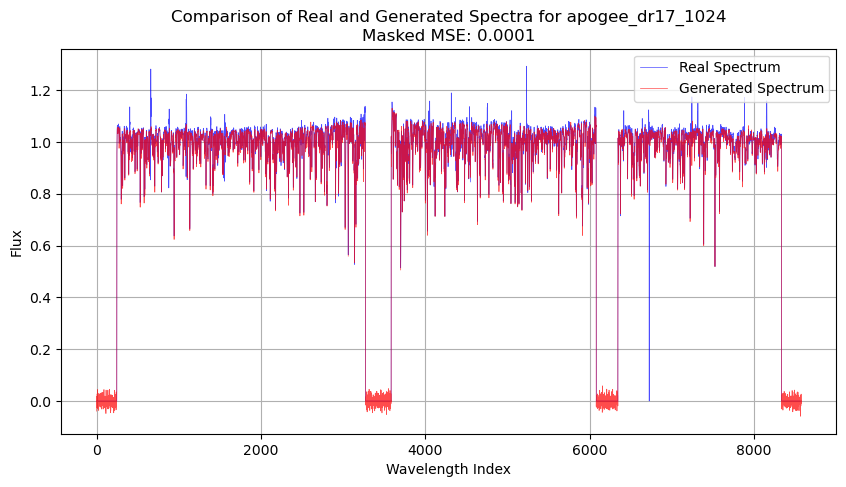

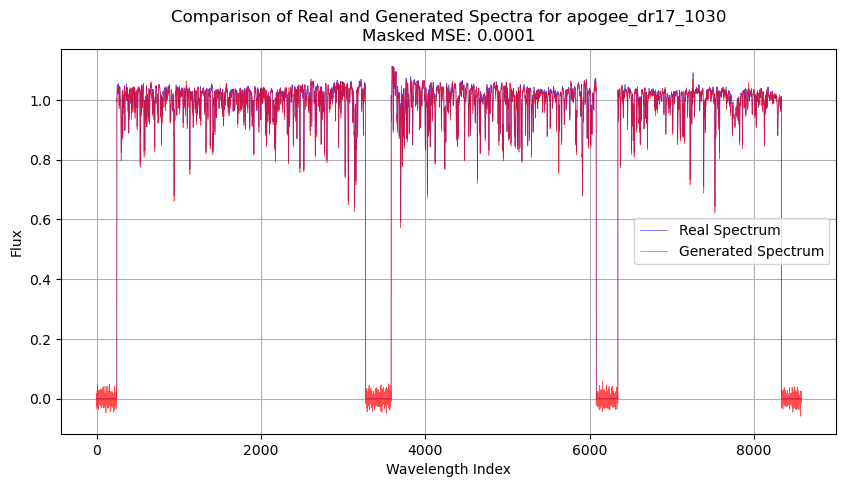

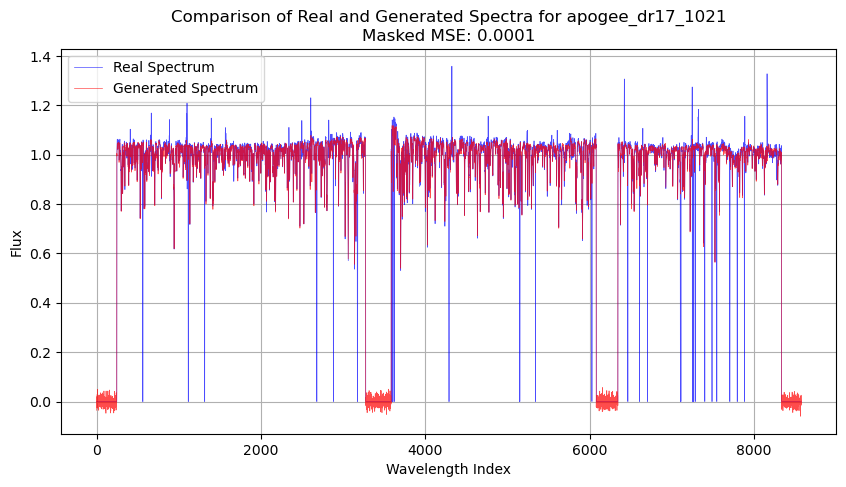

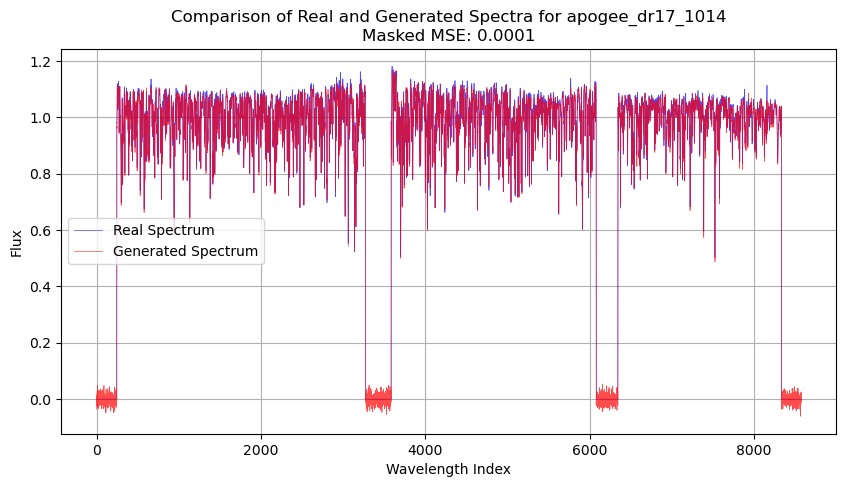

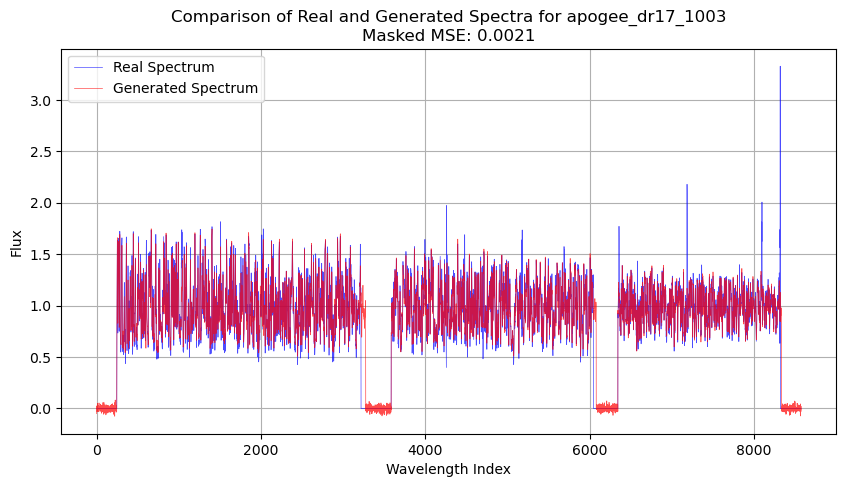

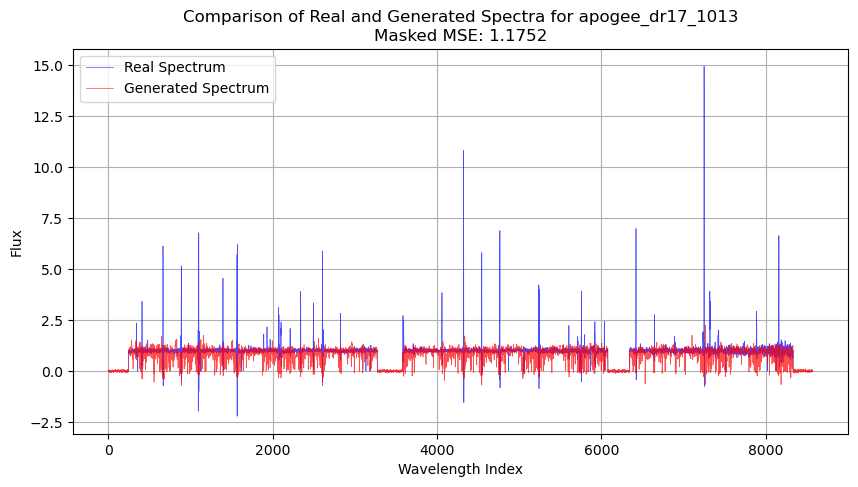

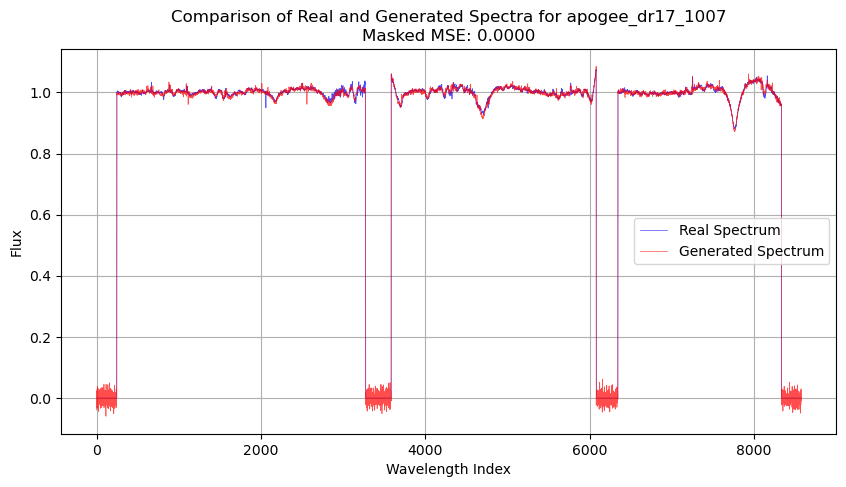

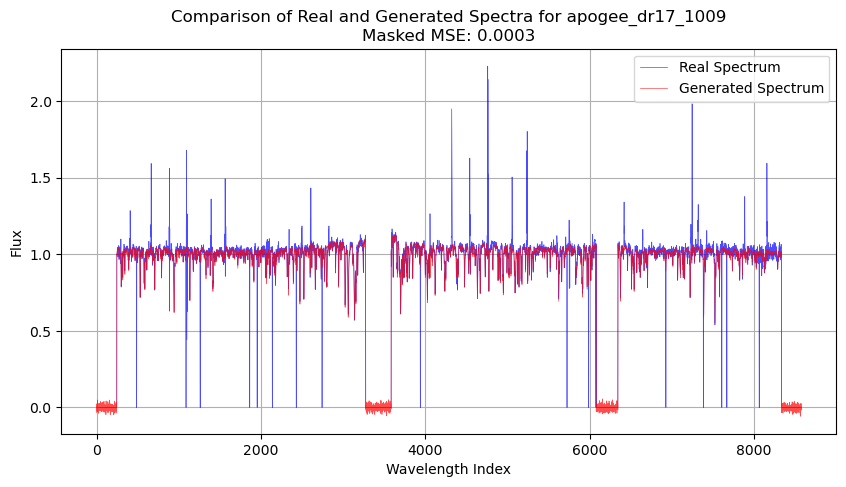

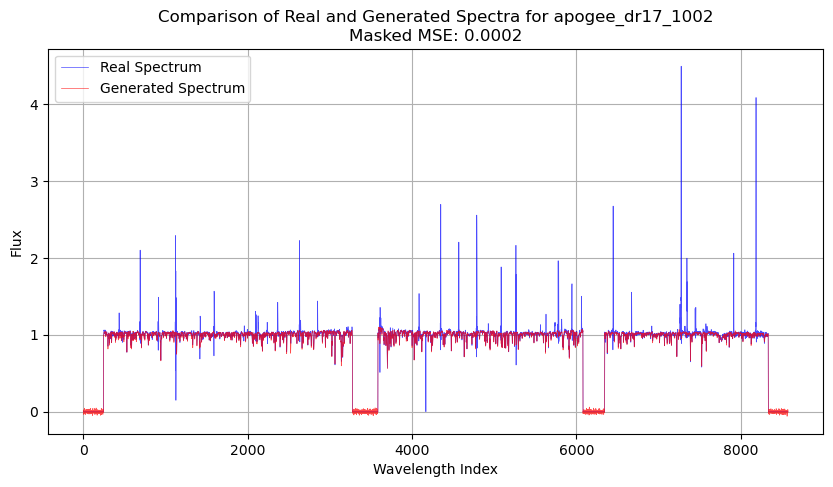

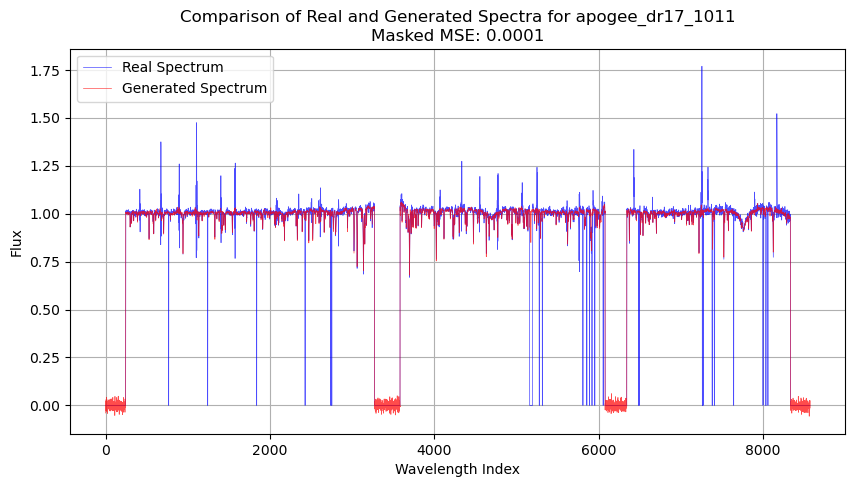

In [12]:
plot_real_vs_generated_batch(dataset, data_path, data_loader, generator, device, 1, plots_path)

In [13]:
def plot_latent_optimization_evolution(data_path, uid, generator, device, max_epoch, plots_path):
    with h5py.File(data_path, 'r') as hdf5_file:
        # Assume the real flux is stored at a specific path, modify as necessary
        real_flux_path = f"{uid}/flux"
        if real_flux_path in hdf5_file:
            real_flux = hdf5_file[real_flux_path][()]

        # Calculate the number of plots needed (initial + every 10 epochs)
        num_plots = 1 + (max_epoch // 10)
        cols = 3  # Set the number of columns for subplots
        rows = (num_plots + cols - 1) // cols  # Calculate rows needed

        fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
        axes = axes.flatten()  # Flatten to iterate easily

        # Plot initial latent code at epoch 0
        initial_latent_code_path = f"{uid}/latent_code"
        if initial_latent_code_path in hdf5_file:
            latent_code = torch.tensor(hdf5_file[initial_latent_code_path][()]).to(device)
            with torch.no_grad():
                generated_spectrum = generator(latent_code.unsqueeze(0)).cpu().numpy().squeeze()
            axes[0].plot(real_flux, label='Real Flux', color='blue')
            axes[0].plot(generated_spectrum, label='Generated Spectrum', color='red')
            axes[0].set_title('Epoch 0 - Initial Latent Code')
            axes[0].set_xlabel('Wavelength Index')
            axes[0].set_ylabel('Flux')
            axes[0].legend()

        # Iterate over each epoch to plot the optimized latent codes
        for i, epoch in enumerate(range(10, max_epoch + 1, 10), start=1):
            epoch_key = f"{uid}/optimized_latent_code/epoch_{epoch}"
            if epoch_key in hdf5_file:
                latent_code = torch.tensor(hdf5_file[epoch_key][()]).to(device)
                with torch.no_grad():
                    generated_spectrum = generator(latent_code.unsqueeze(0)).cpu().numpy().squeeze()
                axes[i].plot(real_flux, label='Real Flux', color='blue')
                axes[i].plot(generated_spectrum, label='Generated Spectrum', color='red')
                axes[i].set_title(f'Epoch {epoch}')
                axes[i].set_xlabel('Wavelength Index')
                axes[i].set_ylabel('Flux')
                axes[i].legend()
            else:
                print(f"No optimized latent code available for epoch {epoch}")
                axes[i].set_visible(False)  # Hide axes if no data available

        # Adjust layout and save the figure
        plt.tight_layout()
        plt.savefig(f"{plots_path}/latent_evolution_{uid}.png")
        plt.show()
        plt.close()



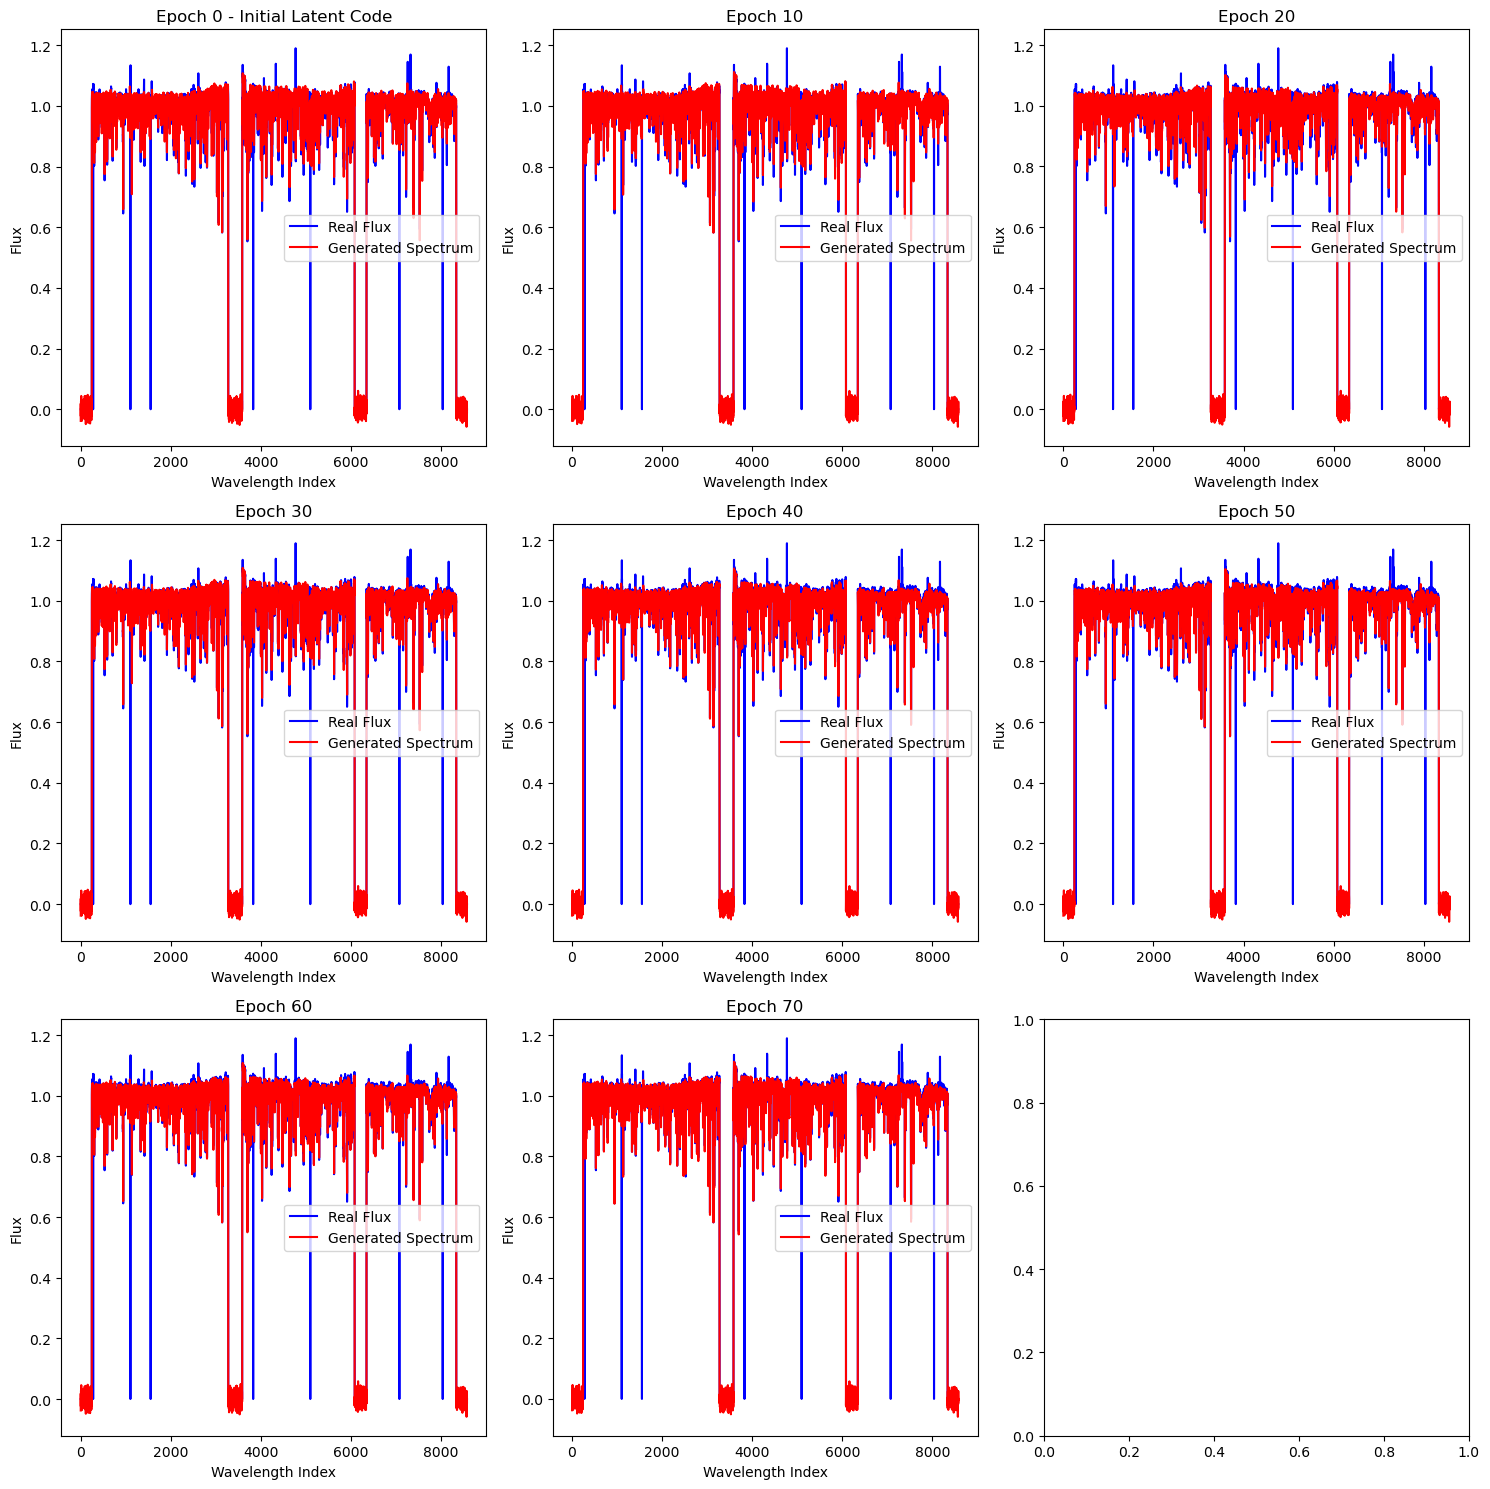

In [14]:
uid = 'apogee_dr17_1006'  

max_epoch = 70  

plot_latent_optimization_evolution(data_path, uid, generator, device, max_epoch, plots_path)


In [17]:
def plot_latent_variable_evolution(data_path, uid, max_epoch, plots_path):
    with h5py.File(data_path, 'r') as hdf5_file:
        epochs = range(0, max_epoch + 1, 5)
        latent_codes = []

        # Collect latent codes across epochs
        for epoch in epochs:
            if epoch == 0:
                latent_code_path = f"{uid}/latent_code"
            else:
                latent_code_path = f"{uid}/optimized_latent_code/epoch_{epoch}"

            if latent_code_path in hdf5_file:
                latent_code = hdf5_file[latent_code_path][()]
                latent_codes.append(latent_code)
            else:
                print(f"No latent code available for epoch {epoch}")
                latent_codes.append(None)

        # Convert list of latent codes to a NumPy array for easier manipulation
        # Filter out None entries and stack arrays
        valid_latent_codes = [code for code in latent_codes if code is not None]
        if not valid_latent_codes:
            raise ValueError("No valid latent codes found.")
        latent_codes_matrix = np.stack(valid_latent_codes)

        # Plotting
        plt.figure(figsize=(12, 8))
        num_latent_vars = latent_codes_matrix.shape[1]  # Number of latent variables
        colors = plt.cm.viridis(np.linspace(0, 1, num_latent_vars))  # Generate distinct colors

        for i in range(num_latent_vars):
            # Extract the i-th latent variable across all epochs
            latent_variable_evolution = latent_codes_matrix[:, i]
            plt.plot(epochs[:len(latent_variable_evolution)], latent_variable_evolution, label=f'Latent {i+1}', color=colors[i])

        plt.title(f'Evolution of Latent Variables for {uid}')
        plt.xlabel('Epoch')
        plt.ylabel('Latent Variable Value')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{plots_path}/latent_evolution_{uid}.png")
        plt.show()
        plt.close()





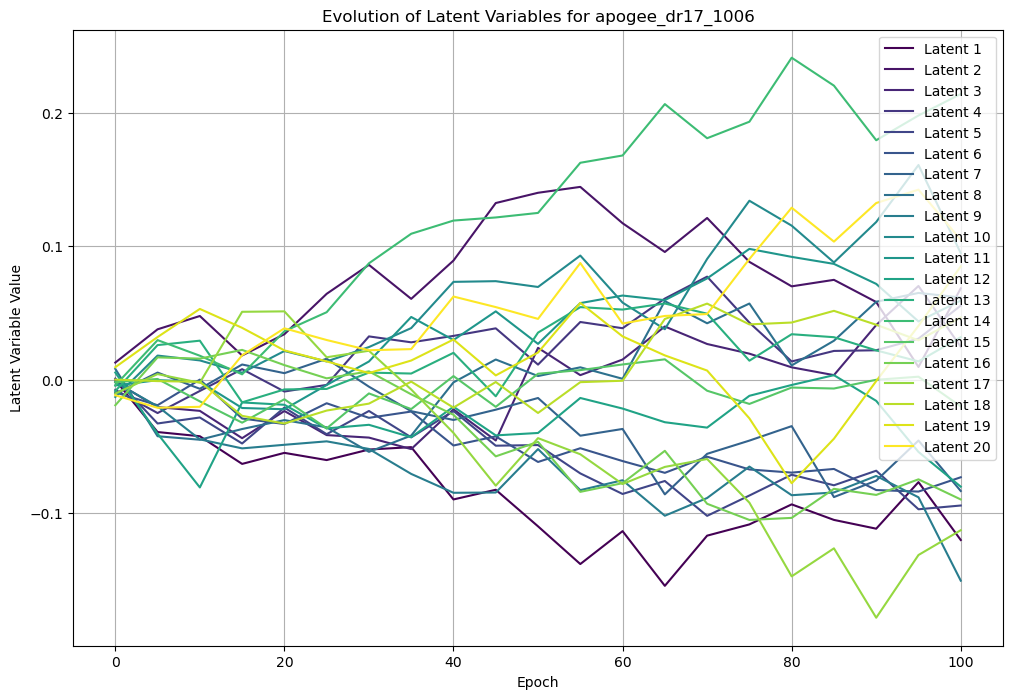

In [18]:
plot_latent_variable_evolution(data_path, uid, 100, plots_path)